# Tropical Cyclone forecast

This notebook introduces the Prithvi-WxC model and demonstrates how to perform a 12 hour forecasting using unrolling.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Model input data

The pre-trained Prithvi-WxC model takes as input three tensors (data cubes) containing different kinds of information:

 - Dynamic input (``x``): A 4-D tensor with shape $(n_t, n_v, n_{lat}, n_{lon})$ containing along its axes the input time steps ($n_t = 2$), the dynamic MERRA-2 variables ($n_v$), the grid-points along the latitudinal dimension, and the grid points along their longitudinal dimension ($n_lon = 576$).
 - Static input (``static``): A tensor with shape $(n_{v_s}, n_{lat}, n_lon{lon})$ containing static input data 
   including the position of each input grid point, the initialization time of the forecast, as well as static MERRA-2 variables.
 - The climatology (``climate``): A tensor with shape $(n_v, n_{lat}, n_{lon})$ containing the climatology for all dynamic variables at the targeted lead time.

## Downloading the data

To be able to perform inference with the Prithvi-WxC model, we first need to download the data required input data. For a given data, we need:

 - MERRA-2 data from these days
 - The static MERRA-2 data
 - Climatology files containing the climatology data used by the Prithvi-WxC model

The ``fm4a`` package provides a helper function to download all required data to perform inference with the Prithvi-WxC model. To use the function you need to make an account with at [NASA EarthData](https://urs.earthdata.nasa.gov/) and [link your](https://urs.earthdata.nasa.gov/approve_app?client_id=e2WVk8Pw6weeLUKZYOxvTQ) account to access the MERRA-2 online archive.

Execute the cell below to download the required input data for a forecasts initialized at August 28, 2021, using a 6-hour time step up to a maximum forecast time of 120 h. The extracted input data for the model will be placed into a folder called ``input_data`` and the downloaded raw data will be stored in a folder ``../data``. 

> **Note**: that the MERRA-2 files are fairly large, so the download will take some time.

     

In [2]:
%rm /home/simon/src/fm4a/data/2021/08/31/MERRA2_401.inst3_3d_asm_Nv.20210831.nc4

rm: cannot remove '/home/simon/src/fm4a/data/2021/08/31/MERRA2_401.inst3_3d_asm_Nv.20210831.nc4': No such file or directory


In [3]:
import numpy as np
from fm4a.download import get_prithvi_wxc_input

#initialization_time =np.datetime64("2020-01-01")
initialization_time =np.datetime64("2021-08-27")
get_prithvi_wxc_input(
    initialization_time,
    6, # The time difference in hours between consecutive model steps.
    6 * 24, # Total maximum lead time.
    "input_data",
    "../data"
)

/home/simon/miniconda3/envs/fm4a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GES DISC username:  pansat
GES DISC password:  ········


HTTPError: 401 Client Error: Unauthorized for url: https://urs.earthdata.nasa.gov/oauth/authorize/?scope=uid&app_type=401&client_id=e2WVk8Pw6weeLUKZYOxvTQ&response_type=code&redirect_uri=https%3A%2F%2Fgoldsmr4.gesdisc.eosdis.nasa.gov%2Fdata-redirect&state=aHR0cHM6Ly9nb2xkc21yNC5nZXNkaXNjLmVvc2Rpcy5uYXNhLmdvdi9kYXRhL01FUlJBMi9NMkkxTlhBU00uNS4xMi40LzIwMjEvMDgvTUVSUkEyXzQwMS5pbnN0MV8yZF9hc21fTnguMjAyMTA4MjcubmM0

In [25]:
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset
from fm4a.definitions import (
    LEVELS,
    SURFACE_VARS,
    STATIC_SURFACE_VARS,
    VERTICAL_VARS,
)
dataset = Merra2RolloutDataset(
    time_range=("2021-08-26", "2021-09-18"),
    lead_time=96,
    input_time=-6,
    data_path_surface="input_data",
    data_path_vertical="input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
len(dataset)# > 0, "There doesn't seem to be any valid data."

9

In [6]:
dataset.valid_climate_timestamps

{(1, 6),
 (1, 12),
 (1, 18),
 (2, 0),
 (2, 6),
 (2, 12),
 (2, 18),
 (3, 0),
 (3, 6),
 (3, 12),
 (3, 18),
 (4, 0),
 (4, 6),
 (4, 12),
 (4, 18),
 (5, 0),
 (5, 6),
 (5, 12),
 (5, 18),
 (6, 0),
 (6, 6),
 (6, 12),
 (6, 18),
 (7, 0),
 (239, 6),
 (239, 12),
 (239, 18),
 (240, 0),
 (240, 6),
 (240, 12),
 (240, 18),
 (241, 0),
 (241, 6),
 (241, 12),
 (241, 18),
 (242, 0),
 (242, 6),
 (242, 12),
 (242, 18),
 (243, 0),
 (243, 6),
 (243, 12),
 (243, 18),
 (244, 0),
 (244, 6),
 (244, 12),
 (244, 18),
 (245, 0)}

In [13]:
from fm4a.download import get_prithvi_wxc_scaling_factors
scaling_factor_dir = Path("scaling_factors")
get_prithvi_wxc_scaling_factors(scaling_factor_dir)

In [16]:
from fm4a.model import load_model
model = load_model(
    "small",
    scaling_factor_dir,
    weights="../data/weights/prithvi_wxc_small.pt"
)
model = model.eval().to(device="cuda:0")

In [18]:
model.encoder_shifter

SWINShiftNoBuffer()

In [28]:
from fm4a.definitions import SURFACE_VARS, STATIC_SURFACE_VARS, VERTICAL_VARS, LEVELS
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset

time_range = ("2021-08-26T00:00:00", "2021-10-01T00:00:00")
input_time_step = -6
lead_time = 108

dataset = Merra2RolloutDataset(
    time_range=time_range,
    lead_time=lead_time,
    input_time=input_time_step,
    data_path_surface="input_data", #"input_data",
    data_path_vertical="input_data", #"input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

In [77]:
lead_time

12

In [44]:
import torch
from torch import Tensor, nn


def rollout_iter(
    nsteps: int,
    model: nn.Module,
    batch: dict[str, Tensor | int | float],
) -> Tensor:
    """A helper function for performing autoregressive rollout.

    Args:
        nsteps (int): The number of rollout steps to take
        model (nn.Module): A model.
        batch (dict): A data dictionary common to the Prithvi models.

    Raises:
        ValueError: If the number of steps isn't positive.

    Returns:
        Tensor: the output of the model after nsteps autoregressive iterations.
    """
    if nsteps < 1:
        raise ValueError("'nsteps' shouold be a positive int.")

    xlast = batch["x"][:, 1]
    batch["lead_time"] = batch["lead_time"][..., 0]

    # Save the masking ratio to be restored later
    mask_ratio_tmp = model.mask_ratio_inputs

    preds = []

    for step in range(nsteps):
        # After first step, turn off masking
        if step > 0:
            model.mask_ratio_inputs = 0.0

        batch["static"] = batch["statics"][:, step]
        batch["climate"] = batch["climates"][:, step]
        batch["y"] = batch["ys"][:, step]

        out = model(batch)
        preds.append(out.cpu().numpy())

        batch["x"] = torch.cat((xlast[:, None], out[:, None]), dim=1)
        xlast = out

    # Restore the masking ratio
    model.mask_ratio_inputs = mask_ratio_tmp

    return preds


In [45]:
import torch
from PrithviWxC.dataloaders.merra2_rollout import preproc

device = "cuda:0"
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}
data = next(iter(dataset))
batch = preproc([data], padding)


for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

    

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = rollout_iter(dataset.nsteps, model, batch)

In [58]:
lats = np.rad2deg(batch["static"][0, 0].cpu().numpy())[:, 0]
lons = np.rad2deg(batch["static"][0, 1].cpu().numpy())[0, :]

In [65]:
slp = [tnsr[0, 9] for tnsr in out]

In [59]:
lon_min = -100
lon_max = -70
lat_min = 15
lat_max = 40

lat_mask = (lat_min < lats) * (lats < lat_max)
lon_mask = (lon_min < lons) * (lons < lon_max)

In [120]:
track = []
for pres in slp:
    pres = pres[lat_mask][..., lon_mask]
    row_ind, col_ind = np.unravel_index(np.argmin(pres), pres.shape)
    track.append([lons[lon_mask][col_ind], lats[lat_mask][row_ind]])

track = np.array(track)

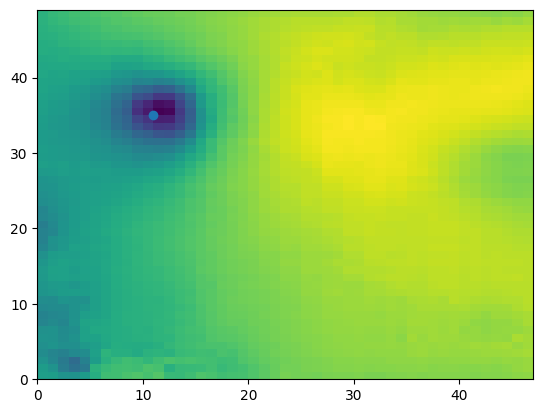

In [121]:
plt.pcolormesh(pres)
row_ind, col_ind = np.unravel_index(np.argmin(pres), pres.shape)
plt.scatter(col_ind, row_ind)

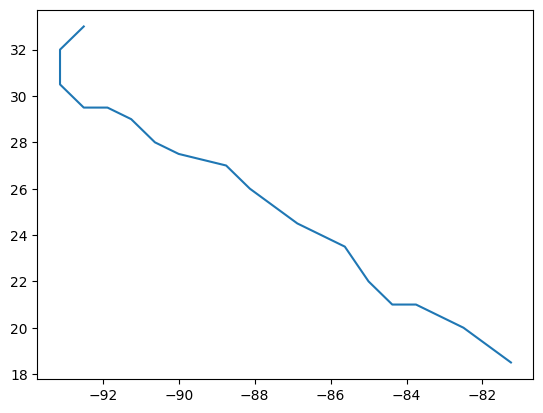

In [122]:
plt.plot(track[:, 0], track[:, 1])

In [127]:
from fm4a.hurdat import get_hurdat_track
hurdat = get_hurdat_track("AL092021")

<xarray.Dataset> Size: 2kB
Dimensions:     (time: 40)
Coordinates:
  * time        (time) datetime64[ns] 320B 2021-08-26T12:00:00 ... 2021-09-04...
    storm_id    <U8 32B 'AL092021'
    storm_name  <U3 12B 'IDA'
Data variables:
    lat         (time) float64 320B 16.5 17.4 18.3 19.4 ... 48.8 48.7 47.6 46.6
    lon         (time) float64 320B -78.9 -79.5 -80.2 ... -63.9 -63.9 -63.5
    wind        (time) int64 320B 30 35 40 45 55 70 70 ... 45 45 45 45 40 35 30
    pressure    (time) int64 320B 1006 1006 1004 1002 996 ... 992 992 996 999
    record_id   (time) <U1 160B '' '' '' '' '' 'L' 'L' ... '' '' '' '' '' '' ''

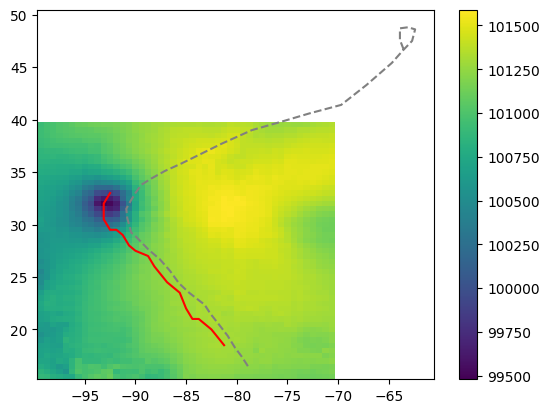

In [134]:
step = 16
plt.pcolormesh(lons[lon_mask], lats[lat_mask], slp[16][lat_mask][..., lon_mask])
plt.plot(track[:, 0], track[:, 1], c="red")
plt.plot(hurdat.lon, hurdat.lat, c="grey", ls="--")
plt.colorbar()

In [57]:
out.shape

torch.Size([1, 160, 360, 576])

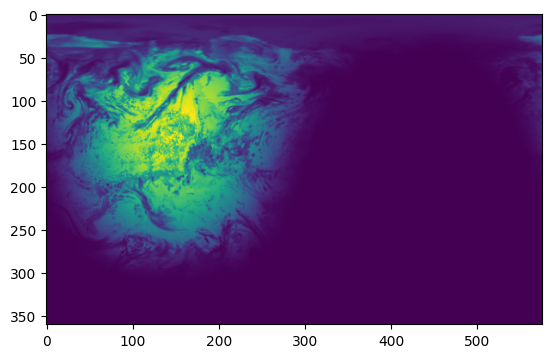

In [97]:
plt.imshow(batch["ys"][0, 1, 10].cpu())

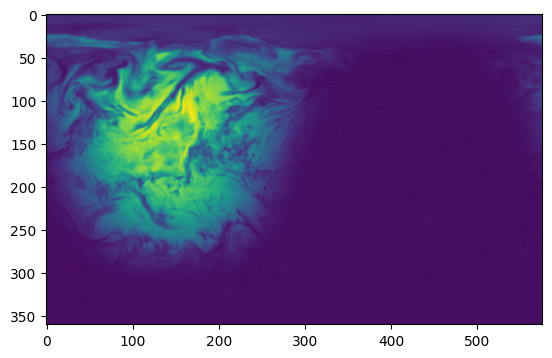

In [96]:
plt.imshow(out[0, 10].cpu())

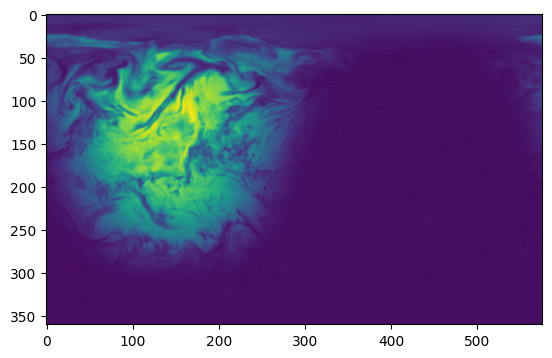

In [93]:
plt.imshow(batch["x"][0, 1, 10].cpu())

In [12]:
cd = xr.load_dataset("raw/constant/MERRA2_101.const_2d_ctm_Nx.00000000.nc4")

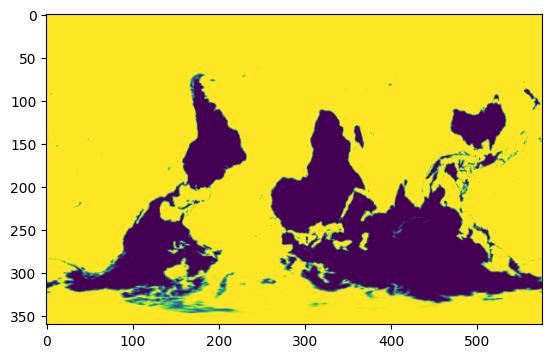

In [13]:
plt.imshow(batch["statics"][0, 0, 6].cpu())

In [14]:
torch.where(torch.isnan(batch["statics"]))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

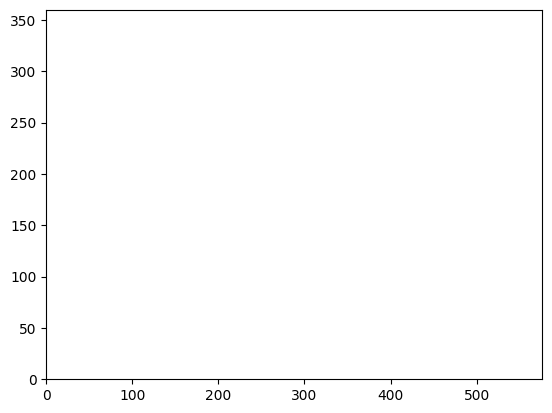

In [16]:
plt.pcolormesh(out[0, 0].cpu())

In [ ]:
from pathlib import Path
from fm4a.download import get_prithvi_wxc_input

download_dir = Path("raw")
input_data_dir = Path("input_data")

get_prithvi_wxc_input(
    np.datetime64("2020-01-01T06:00:00"),
    6,
    12,
    input_data_dir,
    download_dir,
)


In [ ]:
##

In [5]:
https://goldsmr5.gesdisc.eosdis.nasa.gov/data/MERRA2/M2I3NVASM.5.12.4/1970/01/MERRA2_400.inst3_3d_asm_Nv.19700101.nc4
xr.load_dataset("raw/constant/MERRA2_101.const_2d_asm_Nx.00000000.nc4")

<xarray.Dataset> Size: 5MB
Dimensions:    (lon: 576, lat: 361, time: 1)
Coordinates:
  * lon        (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * lat        (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time       (time) datetime64[ns] 8B 1992-01-02T03:00:00
Data variables:
    FRLAKE     (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FRLAND     (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FRLANDICE  (time, lat, lon) float32 832kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    FROCEAN    (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    PHIS       (time, lat, lon) float32 832kB 2.758e+04 2.758e+04 ... 0.0 0.0
    SGH        (time, lat, lon) float32 832kB 11.49 11.49 11.49 ... 0.0 0.0 0.0
Attributes: (12/30)
    History:                           Updated file generated to remove AREA:...
    Comment:                           GMAO filename: d5124_m2_jan79.const_2d...
    Filename:                          MERRA2_101.const_2d_asm_Nx.00000000.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    LatitudeResolution:                0.5 
    LongitudeResolution:               0.625 
    DataResolution:                    0.5 x 0.625 
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/ME5QX6Q5IGGU
    Source:                            CVS tag: GEOSadas-5_12_4